In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers, models
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [3]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'


In [6]:
train_datagen = ImageDataGenerator(rescale=1./255 )
test_datagen = ImageDataGenerator(rescale=1./255 )
val_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(244, 244),
    batch_size=128,
    class_mode='binary'


)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(244 , 244),
    batch_size=128,
    class_mode='binary'

)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(244, 244),
    batch_size=128,
    class_mode='binary'

)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(244,244 , 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),



    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'] )


In [ ]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 242, 242, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 121, 121, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 121, 121, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 119, 119, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 59, 59, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 57, 57, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    51,380,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,751,553 (197.42 MB)

 Trainable params: 51,751,553 (197.42 MB)

 Non-trainable params: 0 (0.00 B)

"I used test data instead of validation data because the number of validation samples is only 16, which is very small, and as a result, the model achieves low accuracy. Therefore, I used test data as validation data to improve the model's performance."

In [ ]:
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=test_generator,

)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.7090 - loss: 0.5589 - val_accuracy: 0.7083 - val_loss: 0.7297
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9113 - loss: 0.2287 - val_accuracy: 0.7212 - val_loss: 1.0508
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9550 - loss: 0.1083 - val_accuracy: 0.7468 - val_loss: 0.8210
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9636 - loss: 0.0908 - val_accuracy: 0.7740 - val_loss: 0.8818
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9749 - loss: 0.0671 - val_accuracy: 0.7356 - val_loss: 1.2182
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9759 - loss: 0.0616 - val_accuracy: 0.7756 - val_loss: 0.8129
Epoch 7/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9775 - loss: 0.0567 - val_accuracy: 0.7356 - val_loss: 1.5498
Epoch 8/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.9770 - loss: 0.0590 - val_accuracy: 0.7516 - val_loss

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7753 - loss: 1.2090
Test Loss: 1.3949928283691406
Test Accuracy: 0.759765625


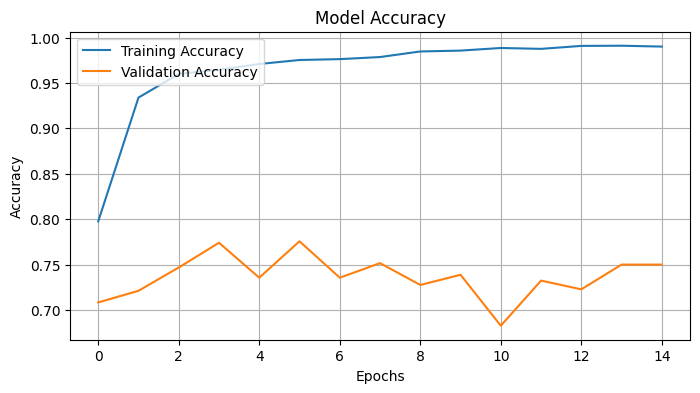

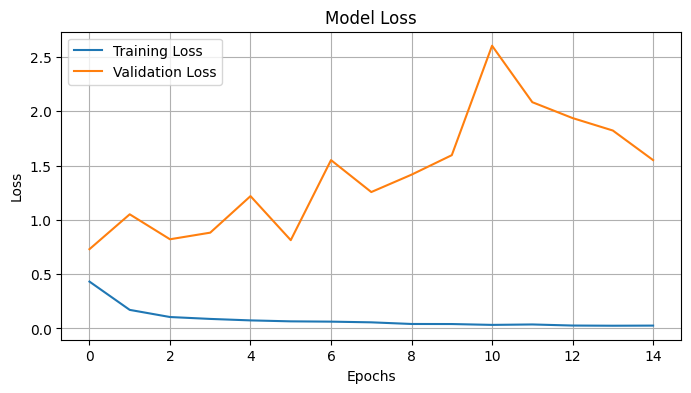

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()


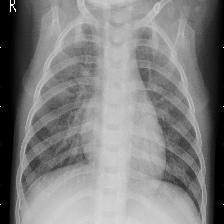

In [ ]:
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step
label = PNEUMONIA


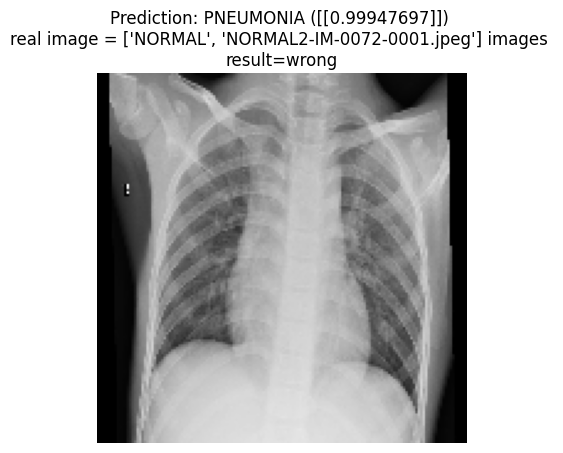

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
label = PNEUMONIA


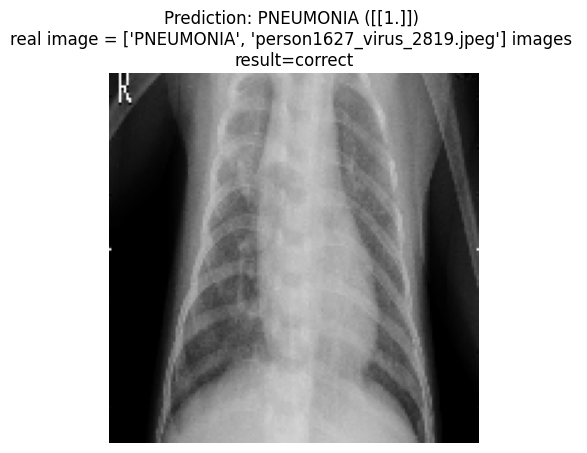

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
label = PNEUMONIA


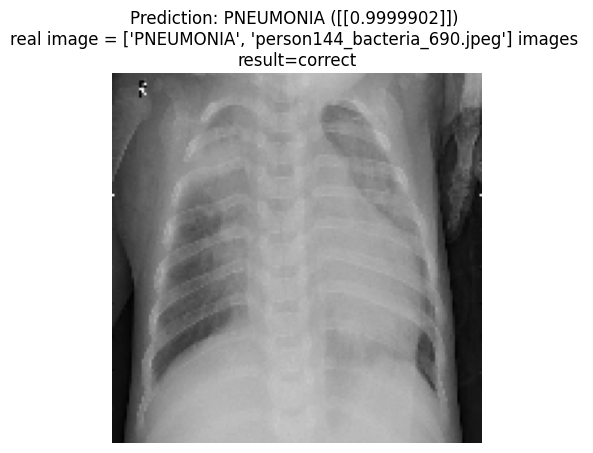

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
label = PNEUMONIA


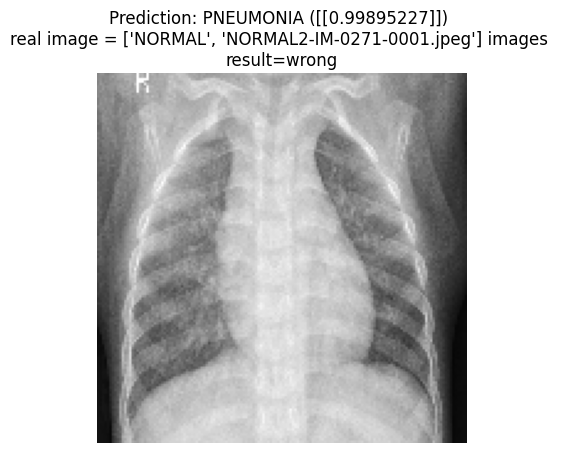

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
label = PNEUMONIA


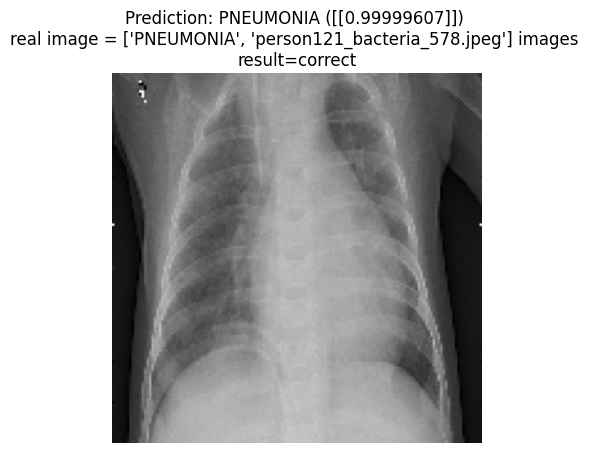

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
label = NORMAL


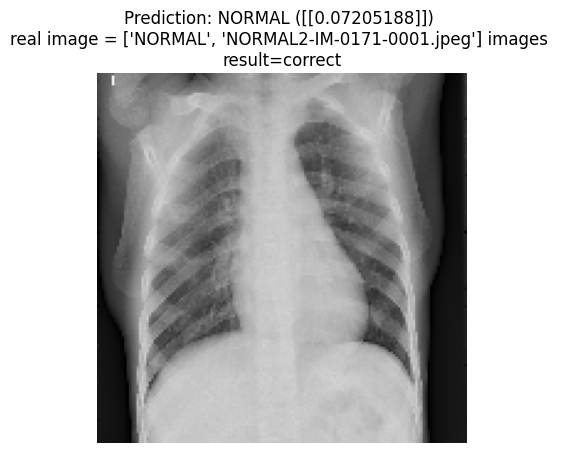

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
label = PNEUMONIA


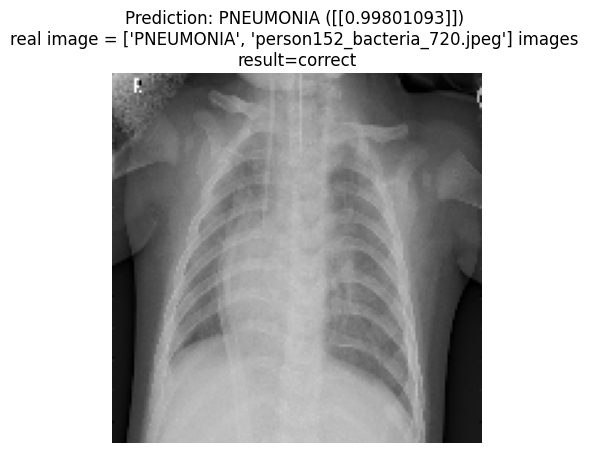

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
label = NORMAL


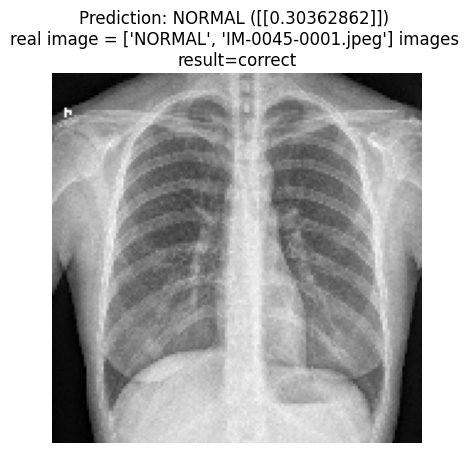

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
label = PNEUMONIA


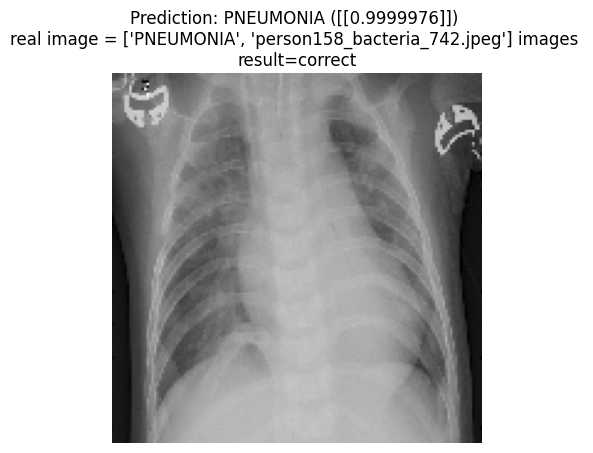

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
label = PNEUMONIA


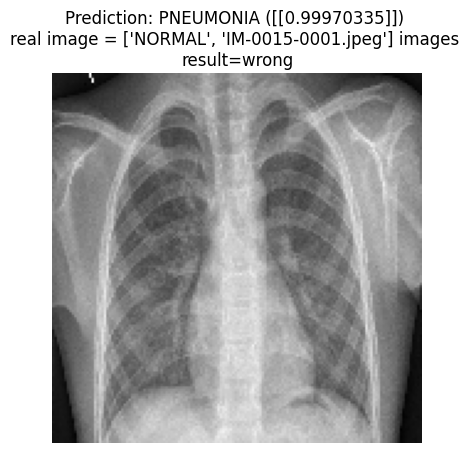

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
label = PNEUMONIA


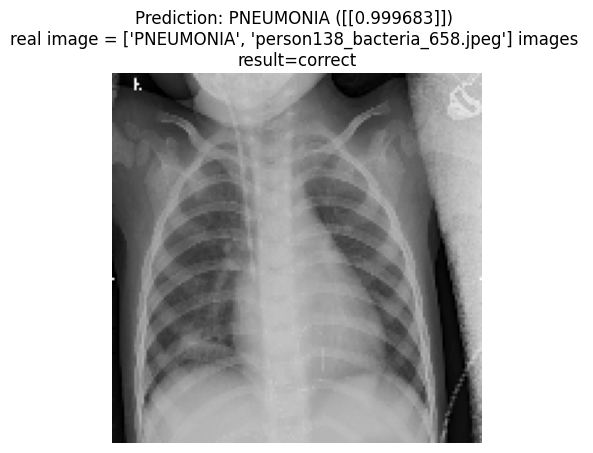

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
label = PNEUMONIA


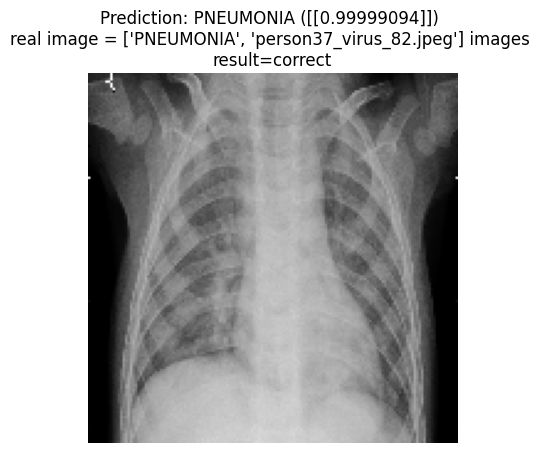

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
label = PNEUMONIA


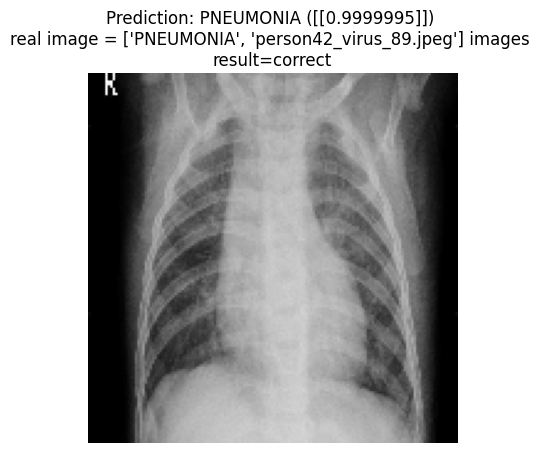

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
label = NORMAL


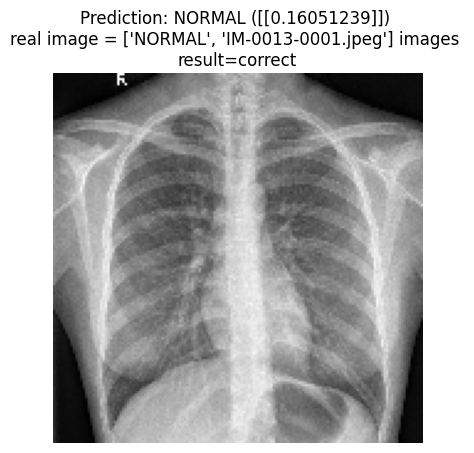

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
label = PNEUMONIA


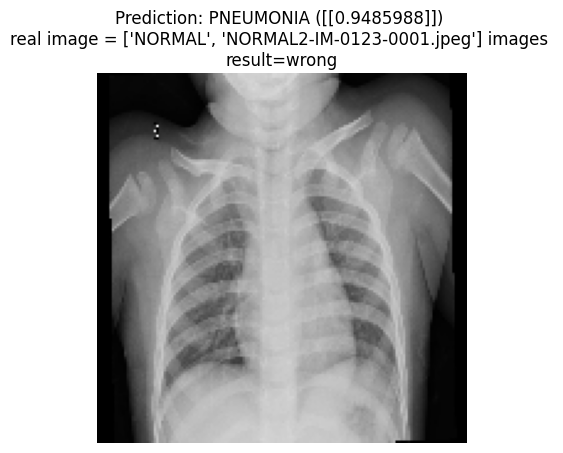

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
label = PNEUMONIA


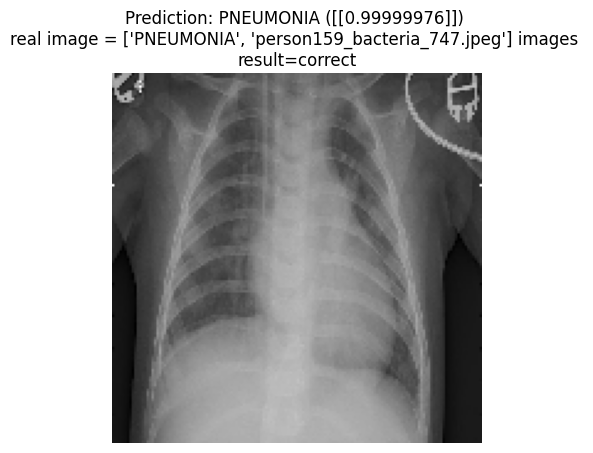

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
label = PNEUMONIA


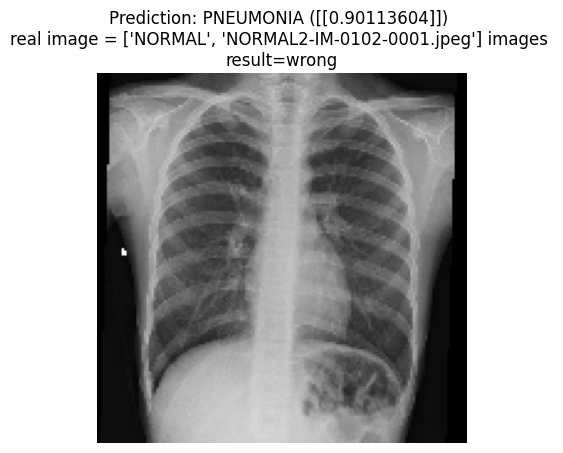

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
label = PNEUMONIA


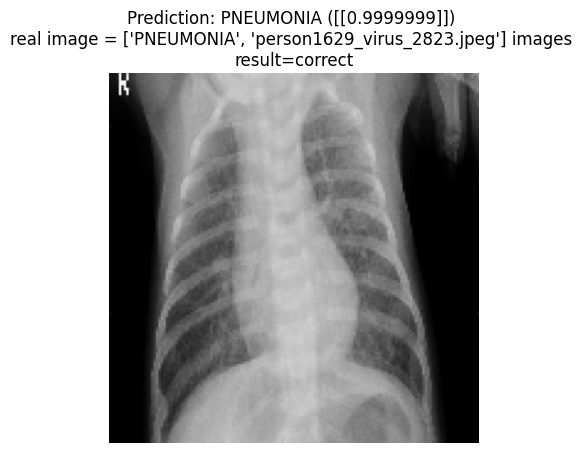

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
label = NORMAL


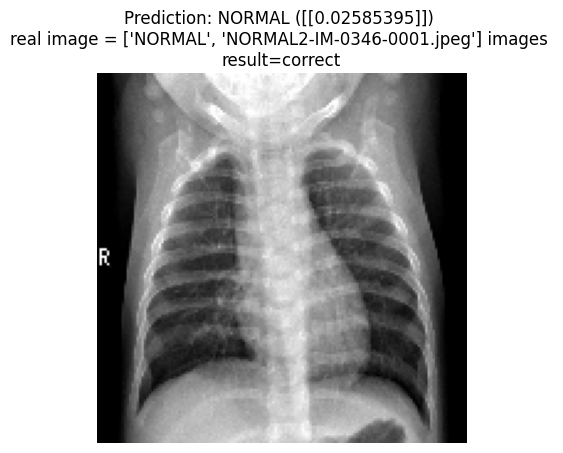

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
label = PNEUMONIA


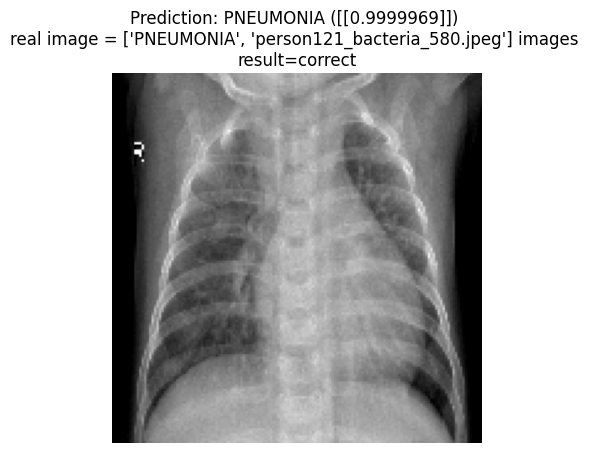

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

NORMAL_images = os.path.join(test_dir, "NORMAL")
PNEUMONIA_images = os.path.join(test_dir, "PNEUMONIA")
category = [NORMAL_images , PNEUMONIA_images]
test_size = 20

for i in range(test_size):
    random_catg = random.choice(category)

    test_image = os.path.join(random_catg, random.choice(os.listdir(random_catg)))
    img = image.load_img(test_image, target_size=(150, 150))

    img_array= image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)

    label = "PNEUMONIA" if prediction[0] > 0.5 else "NORMAL"
    print(f"label = {label}")
    if label in str(random_catg):
        predict_result = "correct"
    else:
        predict_result = "wrong"

    plt.imshow(img)
    plt.title(f"Prediction: {label} ({prediction}) \nreal image = {test_image.split('/')[-2:]} images \nresult = {predict_result}")
    plt.axis('off')
    plt.show()

